# Grape bunch volume regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# display the plots inside the notebook
%matplotlib inline  

# Load the dataset

In [2]:
df_bunches_path = "/home/user/red_globe_2021_datasets/volume_regression_csv/redglobe_2021_dataset.csv"
df_bunches = pd.read_csv(df_bunches_path, parse_dates=['date'], infer_datetime_format=True)
print('Dimension of dataset= ', df_bunches.shape)
df_bunches.head() 

Dimension of dataset=  (422, 10)


/tmp/ipykernel_26698/3148168493.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_bunches = pd.read_csv(df_bunches_path, parse_dates=['date'], infer_datetime_format=True)


bunch_id  west    cut       date      area    avg_depth  not_occluded  \
0    g2p22  True  False 2021-07-27  0.003270  2407.652419         False   
1    g2p24  True  False 2021-07-27  0.005867  1843.647637          True   
2    g1p24  True  False 2021-07-27  0.007088  1566.701201          True   
3    g3p23  True  False 2021-07-27  0.002435  1609.509278         False   
4    g2p23  True  False 2021-07-27  0.002869  1796.876738         False   

   grapes_no      volume      weight  
0         94  470.000000  496.320000  
1         33  151.250000  150.040000  
2         52  238.333333  236.426667  
3         57  190.000000  207.622500  
4         61  203.333333  222.192500

In [3]:
df_bunches.describe()

date        area    avg_depth   grapes_no  \
count                            422  422.000000   422.000000  422.000000   
mean   2021-08-16 09:26:26.729857792    0.003820  1534.600909   75.658768   
min              2021-07-27 00:00:00    0.000392     0.000000   25.000000   
25%              2021-07-27 00:00:00    0.002135     0.000000   57.000000   
50%              2021-08-23 00:00:00    0.003261  1842.953666   72.000000   
75%              2021-09-06 00:00:00    0.005226  2305.430886   91.000000   
max              2021-09-06 00:00:00    0.016817  4471.016275  181.000000   
std                              NaN    0.002306  1060.265731   26.875841   

            volume       weight  
count   422.000000   422.000000  
mean    381.128160   407.683697  
min       0.000000     0.000000  
25%     203.333333   222.192500  
50%     380.000000   401.280000  
75%     560.000000   585.060000  
max    1080.000000  1186.350000  
std     246.087357   265.802247

In [4]:
df_bunches.dtypes

bunch_id                object
west                      bool
cut                       bool
date            datetime64[ns]
area                   float64
avg_depth              float64
not_occluded              bool
grapes_no                int64
volume                 float64
weight                 float64
dtype: object

In [5]:
# remove samples with zero volume and weight
df_filtered = df_bunches[(df_bunches["volume"]>0.0) & (df_bunches["weight"]>0.0)] 
# remove samples that are cut
df_filtered = df_filtered[~df_filtered["cut"]]
# remove samples with zero avg_depth
df_filtered = df_filtered[df_filtered["avg_depth"] > 0.0] 

In [6]:
df_filtered.shape

(222, 10)

In [7]:
num_features = ['area', 'avg_depth'] # numerical features
targets = ["grapes_no", "volume", "weight"] # what if we use grapes_no as a feature?

In [8]:
df_bunches = df_filtered[num_features+targets]

# Boxplot to inspect possible outliers

<Axes: >

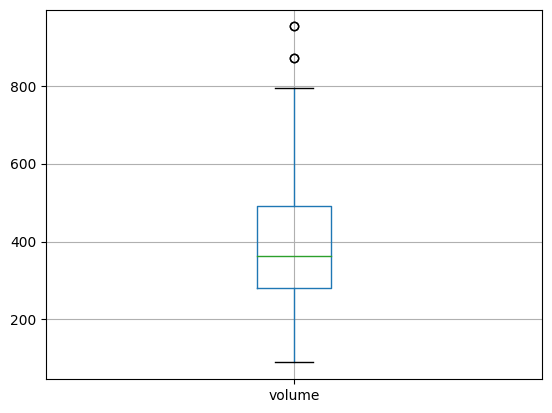

In [9]:
df_filtered.boxplot(column=['volume'])

<Axes: xlabel='area', ylabel='volume'>

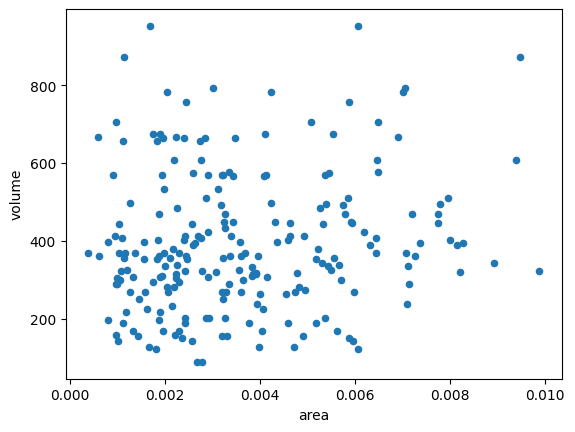

In [10]:
df_filtered.plot.scatter(x='area', y='volume')

In [11]:
df_filtered[(df_filtered['area'] < 0.0005) & (df_filtered['volume'] < 300)]

Empty DataFrame
Columns: [bunch_id, west, cut, date, area, avg_depth, not_occluded, grapes_no, volume, weight]
Index: []

# Mean reduction for multiple samples of the same grape in the same date

In [12]:
# compute the mean of features and targets by grouping on bunch_id and date
df_bunches_mean = df_filtered[['bunch_id','date']+num_features+targets].groupby(['date','bunch_id']).mean()

In [13]:
# IDEA: take the max instead of the mean
# The following instructions need to be revised
# idx = df_filtered[['bunch_id','date']+num_features+targets].groupby(['date','bunch_id'])['area'].transform(max) == df_filtered['area']
# df_bunches_max = df_filtered[idx]

In [14]:
df_bunches_mean.describe()

area    avg_depth   grapes_no      volume      weight
count  95.000000    95.000000   95.000000   95.000000   95.000000
mean    0.003668  2115.082187   70.610526  390.652632  414.590325
std     0.001238   264.694572   24.300554  176.957993  191.736427
min     0.001351  1507.517701   25.000000   89.583333   99.062500
25%     0.002756  1906.751496   53.000000  272.500000  291.154167
50%     0.003518  2122.220241   70.000000  362.250000  376.350000
75%     0.004445  2276.826917   83.500000  477.500000  497.167500
max     0.007118  2849.015070  133.000000  952.000000  989.604000

In [15]:
#  move the 'date' index level back as a regular column
df_bunches_mean_huedate = df_bunches_mean.reset_index(level='date', inplace=False)

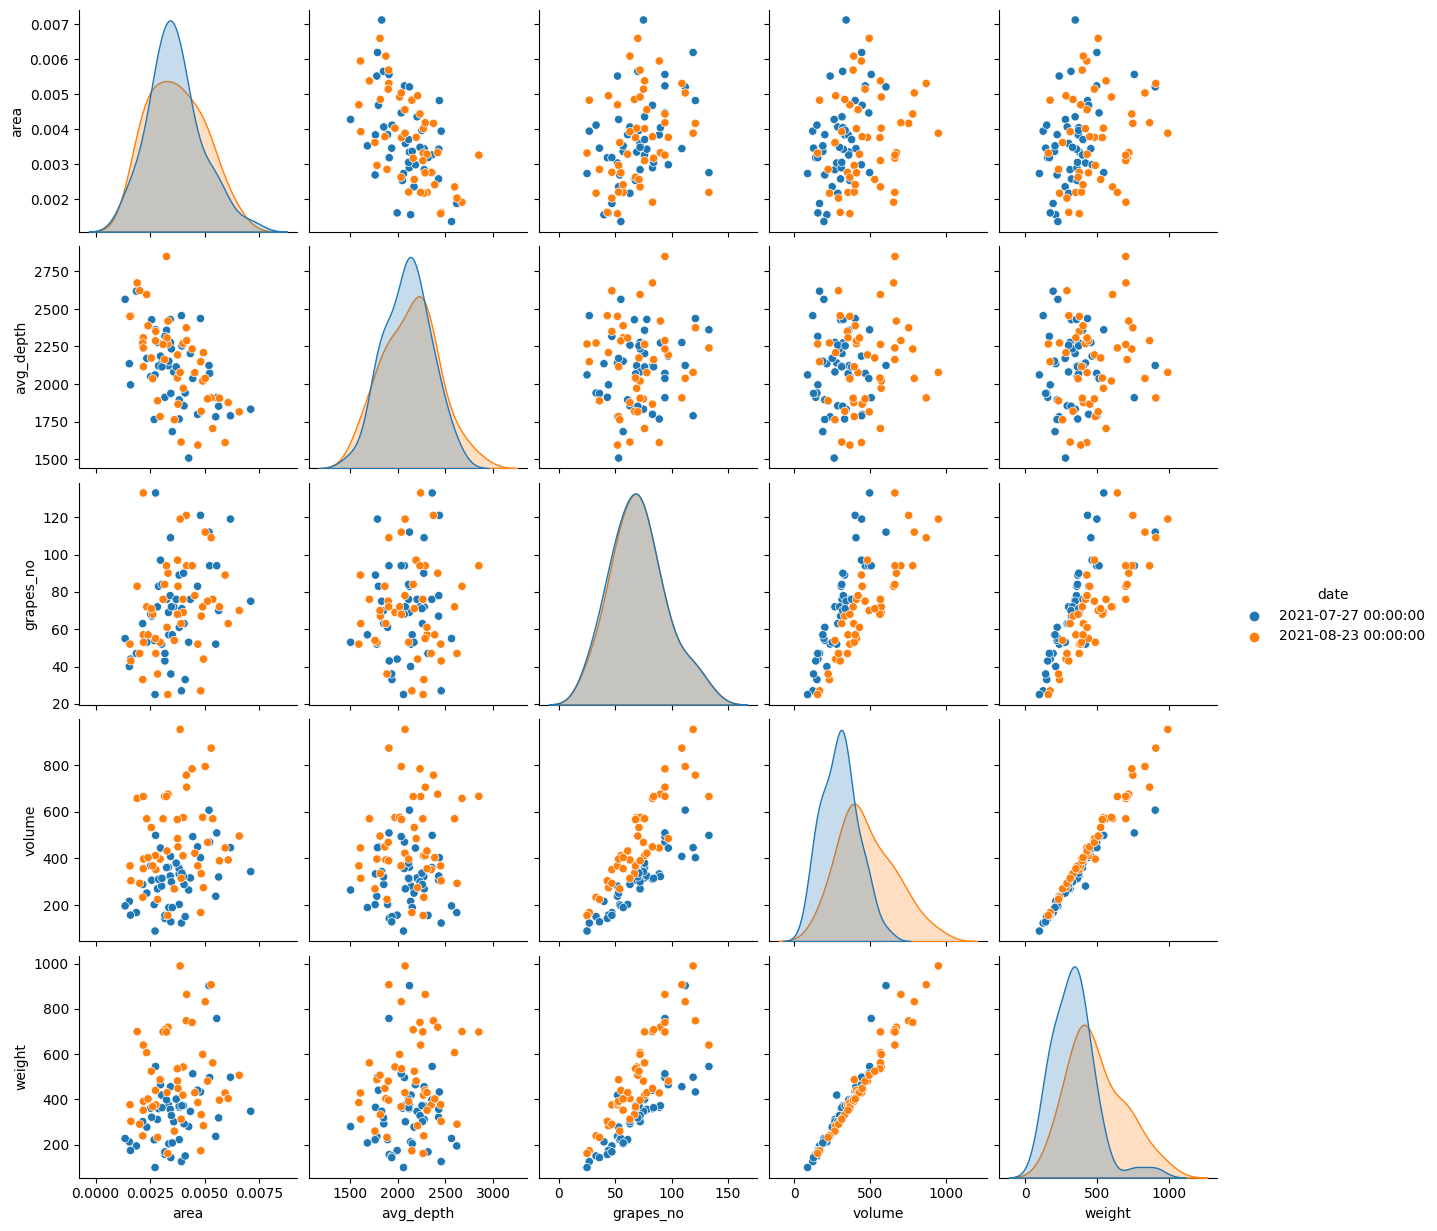

In [16]:
sns.pairplot(df_bunches_mean_huedate, vars=num_features+targets, height=2.5, hue='date')

# Filter out west-side bunches

In [17]:
# take only east-side grape bunches because they have the best illumination
# df_bunches_east = df_filtered[~df_filtered["west"]]
# df_bunches_mean_east = df_bunches_east[['bunch_id','date']+num_features+targets].groupby(['date','bunch_id']).mean()

In [18]:
# df_bunches_mean_east.describe()

# Scale the features

In [19]:
scaler = MinMaxScaler()
scaled_num_features = scaler.fit_transform(df_bunches_mean[num_features]) 
# IDEA: what about scaling the target?

In [20]:
df = df_bunches_mean
features = scaled_num_features
y_volume = df['volume'].to_numpy()
y_weight = df['weight'].to_numpy()

# Apply binning on the volume for a stratified sampling

In [21]:
# introduce a new column volume binned column so to perform stratified splitting
# bins = np.linspace(y_volume.min(),y_volume.max(), 6)
# bins

In [22]:
# df_bunches_mean.loc[:, 'volume_bins'] = pd.cut(df_bunches_mean['volume'], bins=bins, labels=bins[1:], include_lowest=True)

In [23]:
# df_bunches_mean

In [24]:
# df_bunches_mean['volume_bins'].value_counts()

In [25]:
# plot the distribution of volume_bins
# df_bunches_mean['volume_bins'].value_counts().plot(kind='bar')

# Create an interaction feature

In [26]:
# add a new interaction feature
features = np.c_[features, np.power(features[:,0], 3/2)*features[:,1]] 
# add the new interaction feature to the DataFrame
df_bunches_mean.loc[:, 'interaction'] = features[:,2].tolist()

In [27]:
# IDEA: add the interaction feature without the 3/2 power
# features = np.c_[features, features[:,0]*features[:,1]] 
# df_bunches_mean['interaction_nopow'] = features[:,3].tolist()

In [28]:
X = features[:,2] # select the interaction feature

In [29]:
df_bunches_mean.describe()

area    avg_depth   grapes_no      volume      weight  interaction
count  95.000000    95.000000   95.000000   95.000000   95.000000    95.000000
mean    0.003668  2115.082187   70.610526  390.652632  414.590325     0.105606
std     0.001238   264.694572   24.300554  176.957993  191.736427     0.071985
min     0.001351  1507.517701   25.000000   89.583333   99.062500     0.000000
25%     0.002756  1906.751496   53.000000  272.500000  291.154167     0.047038
50%     0.003518  2122.220241   70.000000  362.250000  376.350000     0.093634
75%     0.004445  2276.826917   83.500000  477.500000  497.167500     0.163198
max     0.007118  2849.015070  133.000000  952.000000  989.604000     0.321948

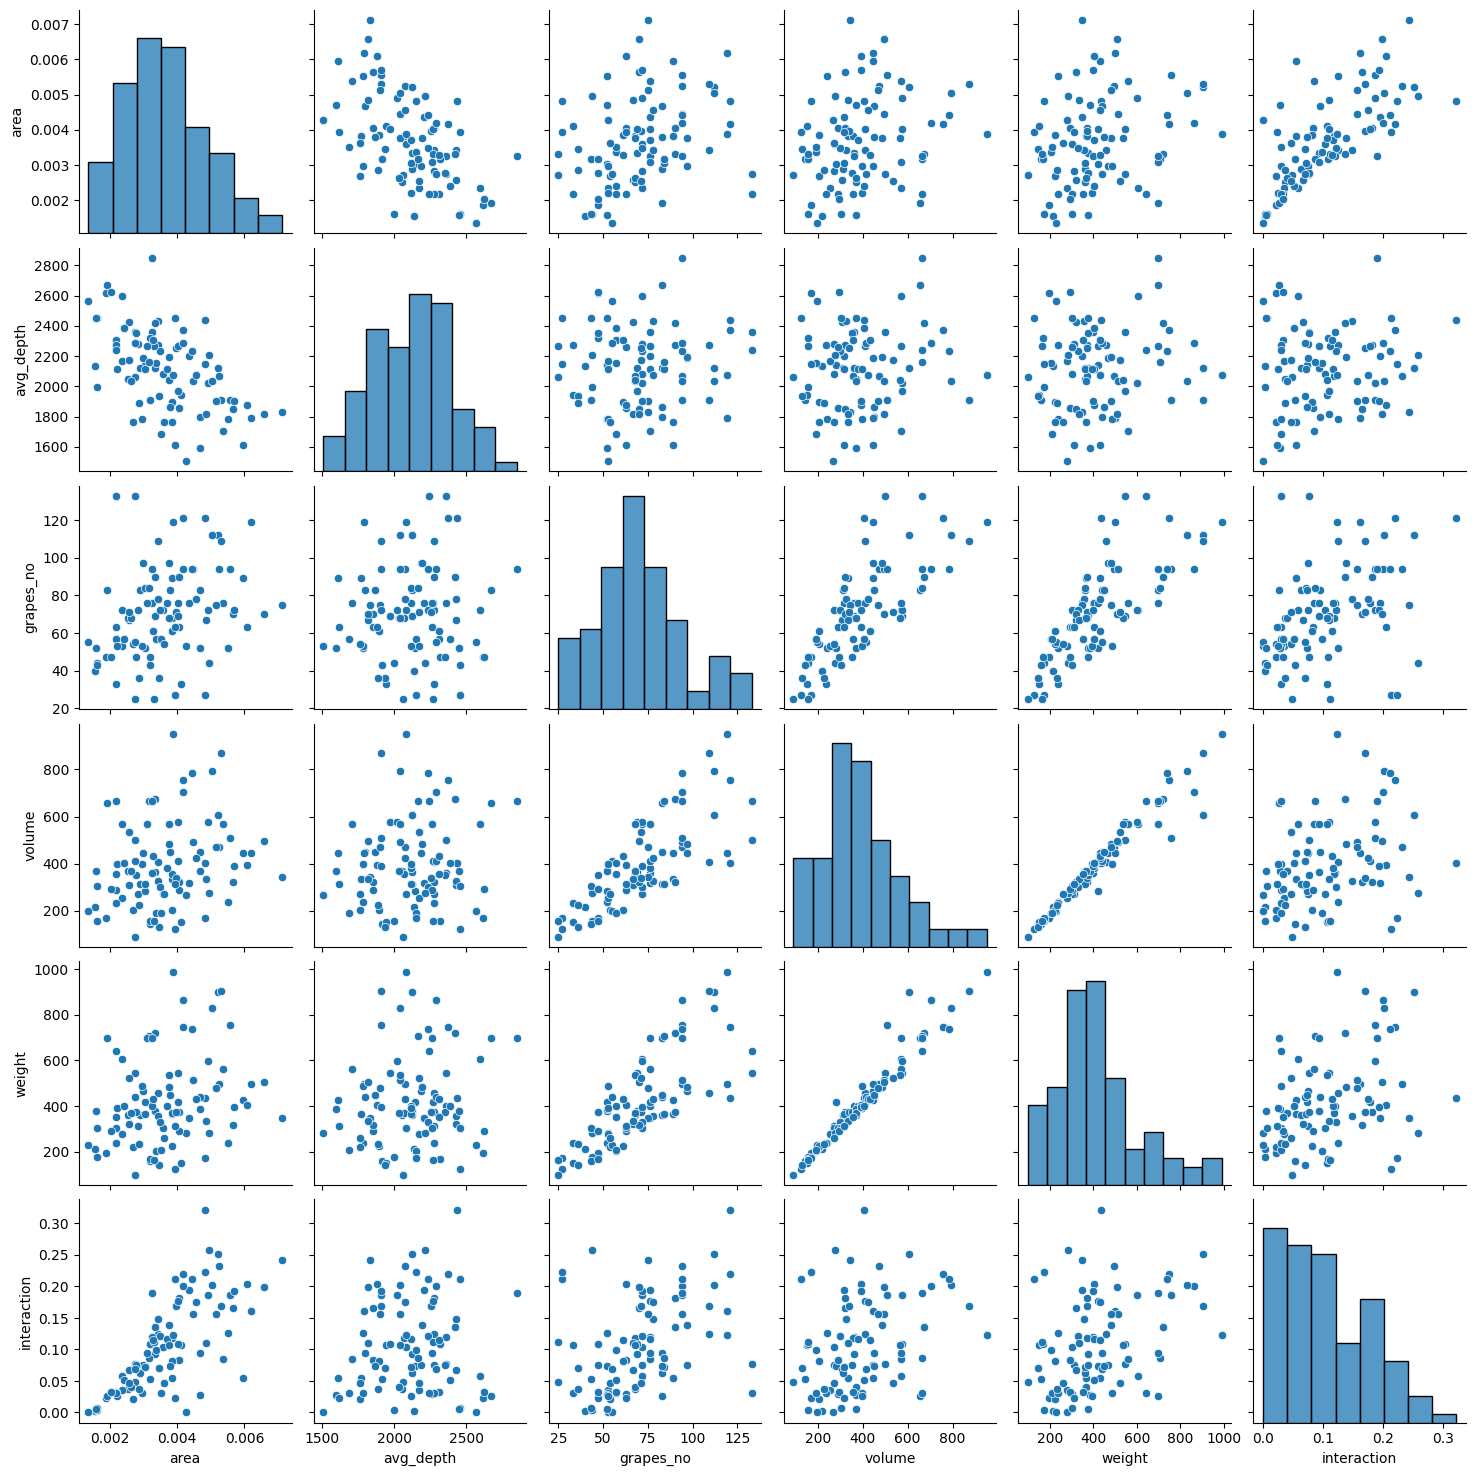

In [30]:
sns.pairplot(df_bunches_mean, vars=num_features+targets+['interaction'], height=2.5)

Text(0, 0.5, 'Actual volume (ml)')

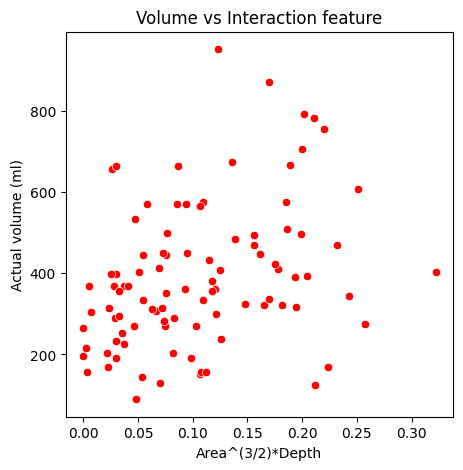

In [31]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x=X, y=y_volume, color='r')
plt.title('Volume vs Interaction feature')
plt.xlabel('Area^(3/2)*Depth')
plt.ylabel('Actual volume (ml)')

In [32]:
fig.savefig('dataset_plot.png', dpi=300)

In [33]:
fig = px.scatter_3d(x=features[:,0], y=features[:,1], z=y_volume)
#fig.update_traces(marker_size = 4)
fig.show()

# Linear regression model

In [81]:
def prepare_df(df, feature_names, target_name, num_bins):
    
    scaler = MinMaxScaler()
    features = scaler.fit_transform(df[feature_names])
    y = df[target_name].to_numpy()
    if num_bins > 0:
        bins = np.linspace(y.min(),y.max(),num_bins)
        df[target_name+'_bins'] = pd.cut(df[target_name], bins=bins, labels=bins[1:], include_lowest=True)
    features = np.c_[features, np.power(features[:,0], 3/2)*features[:,1]] 
    # add the new interaction feature to the DataFrame
    df.loc[:, 'interaction'] = features[:,2].tolist()

    return df, features, y

In [35]:
# repeat linear regression on 100 random splits and returns the average score
def fit_evaluate_100_linear_regression(X, y, stratify):
    test_size = 0.3
    test_r2_scores = []
    test_rmse_scores = []
    # Split X and y into train and test
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                       shuffle=True,
                                                       stratify=stratify)


        # Fit a LinearRegression model
        model = LinearRegression(fit_intercept=True) # 1- model selection
        model = model.fit(X_train, y_train)          # 2- model fitting
        y_predict_test = model.predict(X_test)       # 3- prediction
        y_predict_train = model.predict(X_train)
    
        test_r2_scores.append(r2_score(y_test, y_predict_test))
        test_rmse_scores.append(mean_squared_error(y_test, y_predict_test, squared=False))

    return test_r2_scores, test_rmse_scores

In [62]:
def print_scores(r2_scores, rmse_scores):
    print("R2 score: %.2f (+/- %.2f)" % (np.mean(r2_scores), np.std(r2_scores)))
    print("RMSE score: %.2f (+/- %.2f)" % (np.mean(rmse_scores), np.std(rmse_scores)))

In [36]:
clf = LinearRegression(fit_intercept=True)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(clf, X.reshape(-1, 1), y_volume, cv=cv, scoring='r2')

In [37]:
cv_negmse_scores = cross_val_score(clf, X.reshape(-1, 1), y_volume, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_negmse_scores)

In [63]:
print_scores(cv_r2_scores, cv_rmse_scores)

R2 score: 0.07 (+/- 0.12)
RMSE score: 165.07 (+/- 29.02)


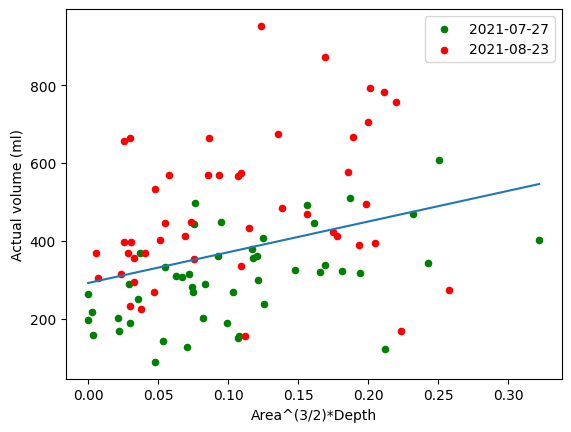

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1, 1), y_volume, test_size=0.3, shuffle=True,)

# Fit a LinearRegression model
model = LinearRegression(fit_intercept=True) # 1- model selection
model = model.fit(X_train, y_train)   
fig, a = plt.subplots(1,1)
df_bunches_mean.xs('2021-07-27').plot(x='interaction', y='volume', ax=a, kind='scatter', color='g')
df_bunches_mean.xs('2021-08-23').plot(x='interaction', y='volume', ax=a, kind='scatter', color='r')
xgrid = np.linspace(np.min(X), np.max(X), 100)
a.plot(xgrid, model.predict(xgrid.reshape(100, 1)))
a.set_xlabel("Area^(3/2)*Depth")
a.set_ylabel("Actual volume (ml)")
a.legend(["2021-07-27", "2021-08-23"]);

In [38]:
fig.savefig('fit_plot.png', dpi=300)

# Linearity checks

Text(0, 0.5, 'Residuals')

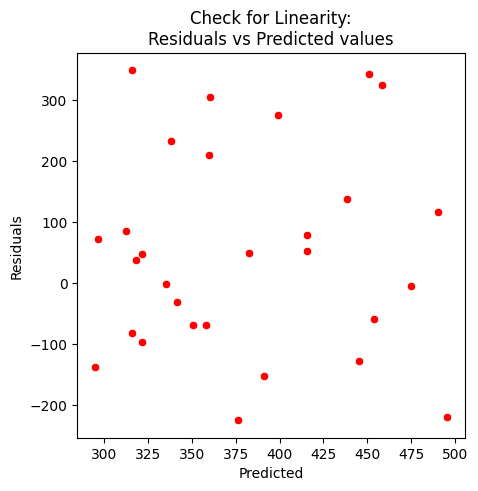

In [40]:
# Check for Linearity

y_predict_test = model.predict(X_test)

# Compute the residuals on the test set
residuals = y_test - y_predict_test

plt.figure(figsize=(5,5))
sns.scatterplot(x=y_predict_test, y=residuals, color='r')
plt.title('Check for Linearity:\nResiduals vs Predicted values')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

Text(0.5, 9.444444444444438, 'Residuals')

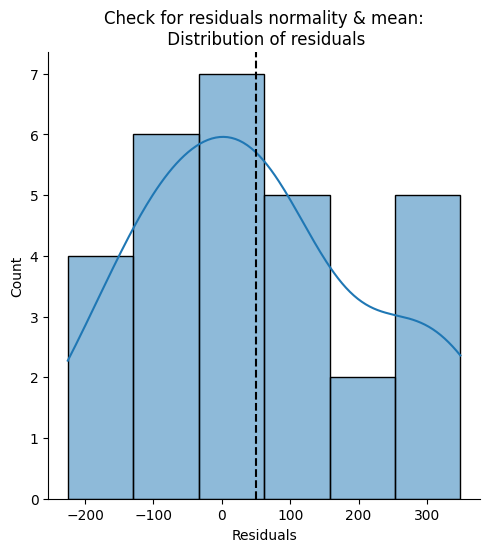

In [41]:
# Check for residuals normality & mean

sns.displot(data=residuals, kind='hist', kde=True)
plt.axvline(residuals.mean(), color='k', linestyle='--')
plt.title('Check for residuals normality & mean:\n Distribution of residuals');
plt.xlabel('Residuals')

Text(0.5, 1.0, 'Correlation of Predictors')

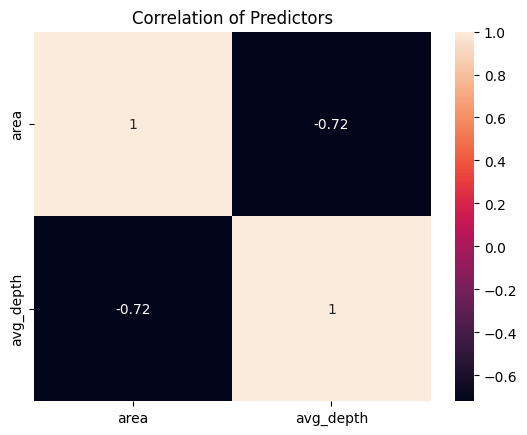

In [42]:
# Plotting the correlation matrix 

sns.heatmap(df_bunches[num_features].corr(), annot=True)
plt.title('Correlation of Predictors')

In [43]:
from statsmodels.stats.stattools import durbin_watson


print('\nPerforming Durbin-Watson Test')
print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
print('0 to 1.5 is positive autocorrelation')
print('2.5 to 4 is negative autocorrelation')
print('-------------------------------------')
durbinWatson = durbin_watson(residuals)
print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

ModuleNotFoundError: No module named 'statsmodels'

Text(0, 0.5, 'Residuals')

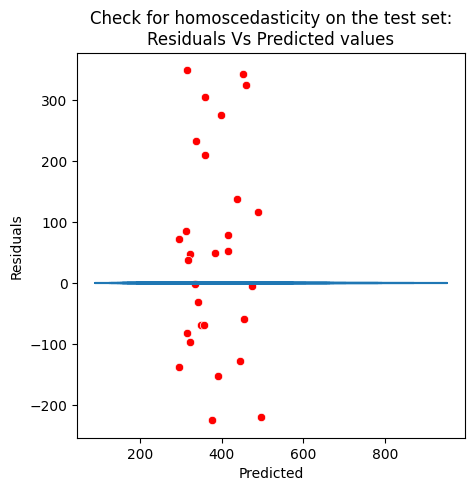

In [48]:
# Check for homoscedasticity

plt.figure(figsize=(5,5))
sns.scatterplot(x=y_predict_test, y=residuals, color='r') 
plt.title('Check for homoscedasticity on the test set:\nResiduals Vs Predicted values')
plt.plot(y_volume, [0]*len(y_volume))
plt.xlabel('Predicted')
plt.ylabel('Residuals')

In [45]:
y_pred = model.predict(X.reshape(-1, 1))

Text(0, 0.5, 'Residuals')

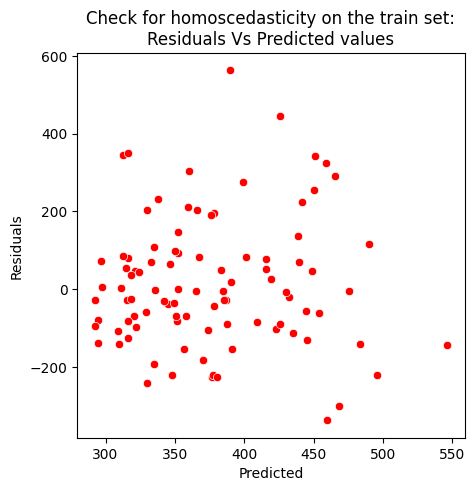

In [49]:
# Check for Homoscedasticity

plt.figure(figsize=(5,5))
sns.scatterplot(x=y_pred, y=(y_volume-y_pred), color='r') 
plt.title('Check for homoscedasticity on the train set:\nResiduals Vs Predicted values')
plt.xlabel('Predicted')
plt.ylabel('Residuals')

# Beta parameters statistics

In [50]:
beta_hat_0 = model.intercept_
beta_hat_1 = model.coef_[0]

In [51]:
print(beta_hat_0, beta_hat_1)

292.2411964260474 788.6900784069996


In [52]:
# Compute the squared standard error of beta_0 and beta_1

n = X_train.shape[0]
X_mean = X_train.mean()

RSS = ((y_train - (beta_hat_0 + beta_hat_1 * X_train).squeeze())**2).sum()
RSE2 = RSS / (n-2)
print("RSE =", np.sqrt(RSE2))

se2_beta_0 = RSE2 * (1.0/n + (X_mean**2) / ((X_train-X_mean)**2).sum())
se2_beta_1 = RSE2 / ((X_train-X_mean)**2).sum()

print("SE(beta_0)^2 = {} \nSE(beta_1)^2 = {}".format(se2_beta_0, se2_beta_1))

RSE = 166.36515301141424
SE(beta_0)^2 = 1354.4944753384364 
SE(beta_1)^2 = 88256.23891184568


In [53]:
percentage_error = np.sqrt(RSE2)/y_train.mean()*100
percentage_error

44.55109540225799

In [54]:
from scipy.stats import t

deg = n-2
confidence = 0.95
value = t.ppf((1 + confidence) / 2., deg)

# Compute the confidence interval for \beta_0
left_beta0 = beta_hat_0 - value * np.sqrt(se2_beta_0)
right_beta0 = beta_hat_0 + value * np.sqrt(se2_beta_0)

# Compute the confidence interval for \beta_1
left_beta1 = beta_hat_1 - value * np.sqrt(se2_beta_1)
right_beta1 = beta_hat_1 + value * np.sqrt(se2_beta_1)

print("The interval [{0:.3f}, {1:.3f}] contains the true beta_0 with {2}% probability".
     format(left_beta0, right_beta0, 100*confidence))
print("The interval [{0:.3f}, {1:.3f}] contains the true beta_1 with {2}% probability".
     format(left_beta1, right_beta1, 100*confidence))

The interval [218.718, 365.765] contains the true beta_0 with 95.0% probability
The interval [195.206, 1382.175] contains the true beta_1 with 95.0% probability


In [55]:
# Set alpha small
alpha = 0.01
# Compute the t-statistic  under H0
t_stat = (beta_hat_1 - 0) / np.sqrt(se2_beta_1)
# Compute the p-value
# Note: t.sf(...) = 1 - t.cdf(...)
p_val = 2*t.sf(np.abs(t_stat), deg)

# Compare the p-vale with alpha
print("beta1 (TV)  t-statistic {0:.2f}, p-value {1}".format(t_stat, p_val))
if p_val < alpha:
    print("Reject H0: A relation between X and y exists")
else:
    print("Not Reject H0: A relation between X and y DOEST NOT exist")

beta1 (TV)  t-statistic 2.65, p-value 0.010001144801014663
Not Reject H0: A relation between X and y DOEST NOT exist


In [56]:
# Do the same for beta0 (intercept)
t_stat = (beta_hat_0 - 0) / np.sqrt(se2_beta_0)
p_val = 2*t.sf(np.abs(t_stat), deg)

# Compare the p-vale with alpha
print("beta0 (intercept)  t-statistic {0:.2f}, p-value {1}".format(t_stat, p_val))

beta0 (intercept)  t-statistic 7.94, p-value 4.1028856308727106e-11


## Analysis using not occluded bunches

In [82]:
df_bunches_not_occl = df_filtered[df_filtered["not_occluded"]]
df_bunches_not_occl.describe()

date       area    avg_depth   grapes_no      volume  \
count                   72  72.000000    72.000000   72.000000   72.000000   
mean   2021-08-06 03:00:00   0.005180  1884.116118   71.986111  378.715278   
min    2021-07-27 00:00:00   0.001668  1374.162016   27.000000  123.750000   
25%    2021-07-27 00:00:00   0.003643  1694.388103   53.500000  278.750000   
50%    2021-07-27 00:00:00   0.005350  1835.570166   72.000000  354.750000   
75%    2021-08-23 00:00:00   0.006440  2044.791764   85.250000  469.062500   
max    2021-08-23 00:00:00   0.009869  2622.034588  133.000000  952.000000   
std                    NaN   0.001928   288.024057   24.068267  170.840147   

           weight  
count   72.000000  
mean   411.492676  
min    125.145000  
25%    298.991250  
50%    373.802500  
75%    496.743750  
max    989.604000  
std    196.807773

In [83]:
df_bunches_mean_not_occl = df_bunches_not_occl[['bunch_id','date']+num_features+targets].groupby(['date','bunch_id']).mean()

In [84]:
df, features, y = prepare_df(df_bunches_mean_not_occl, num_features, 'volume', 0)
X = features[:,2] # select the interaction feature

In [69]:
# df['volume_bins'].value_counts().plot(kind='bar')

In [92]:
clf = LinearRegression(fit_intercept=True)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(clf, X.reshape(-1, 1), y, cv=cv, scoring='r2')

In [93]:
cv_negmse_scores = cross_val_score(clf, X.reshape(-1, 1), y, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_negmse_scores)

In [94]:
print_scores(cv_r2_scores, cv_rmse_scores)

R2 score: -0.02 (+/- 0.05)
RMSE score: 163.76 (+/- 24.56)
